In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io as io
import scipy
import sys
sys.path.insert(0, '../')
from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [2]:
seed = 999
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [3]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,20], 50, 128)
res_test, _, _, _, _ = get_data([0,1], [0,20], 100, 256)
num_step=5
step=1e-2
res = make_time_sequence(res, num_step=num_step, step=step)
b_left = make_time_sequence(b_left, num_step=num_step, step=step)
b_right = make_time_sequence(b_right, num_step=num_step, step=step)
b_upper = make_time_sequence(b_upper, num_step=num_step, step=step)
b_lower = make_time_sequence(b_lower, num_step=num_step, step=step)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
model = PINNsformer(d_out=3, d_hidden=512, d_model=32, N=1, heads=1).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

/tmp/ipykernel_6312/1726905252.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [5]:
def model_SEIR(x, t):
    SEIR = model(x, t)
    S = SEIR[:,:, 0]
    E = SEIR[:,:, 1]
    I = SEIR[:,:, 2]
    S = S.unsqueeze(-1)
    E = E.unsqueeze(-1)
    I = I.unsqueeze(-1)
    return S, E, I

In [6]:
loss_track = []

for i in tqdm(range(20)):
    def closure():
        pred_res, pred_ree, pred_rei = model_SEIR(x_res, t_res)
        preds_left, prede_left, predi_left = model_SEIR(x_left, t_left)
        preds_right, prede_right, predi_right = model_SEIR(x_right, t_right)
        preds_upper, prede_upper, predi_upper = model_SEIR(x_upper, t_upper)
        preds_lower, prede_lower, predi_lower = model_SEIR(x_lower, t_lower)

        S_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        S_xx = torch.autograd.grad(S_x, x_res, grad_outputs=torch.ones_like(S_x), create_graph=True)[0]
        S_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        E_x = torch.autograd.grad(pred_ree, x_res, grad_outputs=torch.ones_like(pred_ree), retain_graph=True, create_graph=True)[0]
        E_xx = torch.autograd.grad(E_x, x_res, grad_outputs=torch.ones_like(E_x), create_graph=True)[0]
        E_t = torch.autograd.grad(pred_ree, t_res, grad_outputs=torch.ones_like(pred_ree), retain_graph=True, create_graph=True)[0]

        I_x = torch.autograd.grad(pred_rei, x_res, grad_outputs=torch.ones_like(pred_rei), retain_graph=True, create_graph=True)[0]
        I_xx = torch.autograd.grad(I_x, x_res, grad_outputs=torch.ones_like(I_x), create_graph=True)[0]
        I_t = torch.autograd.grad(pred_rei, t_res, grad_outputs=torch.ones_like(pred_rei), retain_graph=True, create_graph=True)[0]

        def bc_loss_upper(x, t):
            pred_res, pred_ree, pred_rei = model_SEIR(x, t)
            S_x = torch.autograd.grad(pred_res, x, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
            E_x = torch.autograd.grad(pred_ree, x, grad_outputs=torch.ones_like(pred_ree), create_graph=True)[0]
            I_x = torch.autograd.grad(pred_rei, x, grad_outputs=torch.ones_like(pred_rei), create_graph=True)[0]
            return S_x, E_x, I_x

        def bc_loss_lower(x, t):
            pred_res, pred_ree, pred_rei = model_SEIR(x, t)
            S_x = torch.autograd.grad(pred_res, x, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
            E_x = torch.autograd.grad(pred_ree, x, grad_outputs=torch.ones_like(pred_ree), create_graph=True)[0]
            I_x = torch.autograd.grad(pred_rei, x, grad_outputs=torch.ones_like(pred_rei), create_graph=True)[0]
            return S_x, E_x, I_x

        pde1 = S_t - 0.005 * S_xx - 1 + 1.0 * pred_res * pred_rei + 0.1 * pred_res
        pde2 = E_t - 0.005 * E_xx - 1.0 * pred_res * pred_rei + 1.0 * pred_ree + 0.1 * pred_ree
        pde3 = I_t - 0.005 * I_xx - 1.0 * pred_ree + 1.0 * pred_rei + 0.1 * pred_rei

        loss_res = torch.mean(pde1 ** 2) + torch.mean(pde2 ** 2) + torch.mean(pde3 ** 2)

        loss_bcs_1, loss_bce_1, loss_bci_1 = bc_loss_upper(x_upper, t_upper)
        loss_bcs_2, loss_bce_2, loss_bci_2 = bc_loss_lower(x_lower, t_lower)
        loss_bcs_1 = torch.mean(loss_bcs_1[:,0] ** 2)
        loss_bce_1 = torch.mean(loss_bce_1[:,0] ** 2)
        loss_bci_1 = torch.mean(loss_bci_1[:,0] ** 2)
        loss_bcs_2 = torch.mean(loss_bcs_2[:,0] ** 2)
        loss_bce_2 = torch.mean(loss_bce_2[:,0] ** 2)
        loss_bci_2 = torch.mean(loss_bci_2[:,0] ** 2)
        loss_bc = loss_bcs_1 + loss_bce_1 + loss_bci_1 + loss_bcs_2 + loss_bce_2 + loss_bci_2

        loss_ic1 = torch.mean((preds_left[:, 0] - 1 + (torch.sin(np.pi * x_left[:,0]) ** 2) ) ** 2)
        loss_ic2 = torch.mean((predi_left[:, 0] - (torch.sin(np.pi * x_left[:,0]) ** 2)) ** 2)
        loss_ic3 = torch.mean((prede_left[:, 0]) ** 2)
        loss_ic = loss_ic1 + loss_ic2 + loss_ic3
        

        current_losses = [loss_res.item(), loss_bc.item(), loss_ic.item()]
        loss_track.append(current_losses)

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        
        # Print losses for this iteration
        print(f'Iteration {i+1}: Total Loss: {sum(current_losses):.4f}, Loss Res: {current_losses[0]:.4f}, Loss_BC: {current_losses[1]:.4f}, Loss_IC: {current_losses[2]:.4f}')
        
        return loss

    optim.step(closure)

# Final output remains the same
print('Final Losses - Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Final Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 1: Total Loss: 3.4185, Loss Res: 1.7925, Loss_BC: 0.1617, Loss_IC: 1.4644
Iteration 1: Total Loss: 3.2926, Loss Res: 1.7408, Loss_BC: 0.1600, Loss_IC: 1.3917
Iteration 1: Total Loss: 2.3464, Loss Res: 1.3548, Loss_BC: 0.1486, Loss_IC: 0.8430
Iteration 1: Total Loss: 1.2114, Loss Res: 0.8327, Loss_BC: 0.1103, Loss_IC: 0.2685
Iteration 1: Total Loss: 1.0318, Loss Res: 0.6676, Loss_BC: 0.0855, Loss_IC: 0.2788
Iteration 1: Total Loss: 0.7947, Loss Res: 0.3995, Loss_BC: 0.0549, Loss_IC: 0.3403
Iteration 1: Total Loss: 0.5840, Loss Res: 0.2189, Loss_BC: 0.0530, Loss_IC: 0.3121
Iteration 1: Total Loss: 0.4390, Loss Res: 0.1220, Loss_BC: 0.0624, Loss_IC: 0.2545
Iteration 1: Total Loss: 0.4151, Loss Res: 0.1090, Loss_BC: 0.0494, Loss_IC: 0.2568
Iteration 1: Total Loss: 0.3805, Loss Res: 0.0752, Loss_BC: 0.0489, Loss_IC: 0.2564
Iteration 1: Total Loss: 0.3669, Loss Res: 0.0676, Loss_BC: 0.0463, Loss_IC: 0.2530
Iteration 1: Total Loss: 0.3413, Loss Res: 0.0510, Loss_BC: 0.0386, Loss_IC:

  5%|▌         | 1/20 [00:06<02:07,  6.71s/it]

Iteration 1: Total Loss: 0.2639, Loss Res: 0.0145, Loss_BC: 0.0076, Loss_IC: 0.2418
Iteration 2: Total Loss: 0.2639, Loss Res: 0.0145, Loss_BC: 0.0076, Loss_IC: 0.2418
Iteration 2: Total Loss: 0.2609, Loss Res: 0.0130, Loss_BC: 0.0077, Loss_IC: 0.2402
Iteration 2: Total Loss: 0.2593, Loss Res: 0.0124, Loss_BC: 0.0074, Loss_IC: 0.2395
Iteration 2: Total Loss: 0.2571, Loss Res: 0.0119, Loss_BC: 0.0072, Loss_IC: 0.2380
Iteration 2: Total Loss: 0.2547, Loss Res: 0.0107, Loss_BC: 0.0076, Loss_IC: 0.2364
Iteration 2: Total Loss: 0.2530, Loss Res: 0.0099, Loss_BC: 0.0084, Loss_IC: 0.2347
Iteration 2: Total Loss: 0.2517, Loss Res: 0.0094, Loss_BC: 0.0089, Loss_IC: 0.2334
Iteration 2: Total Loss: 0.2493, Loss Res: 0.0084, Loss_BC: 0.0100, Loss_IC: 0.2309
Iteration 2: Total Loss: 0.2468, Loss Res: 0.0080, Loss_BC: 0.0117, Loss_IC: 0.2271
Iteration 2: Total Loss: 0.2450, Loss Res: 0.0073, Loss_BC: 0.0134, Loss_IC: 0.2243
Iteration 2: Total Loss: 0.2435, Loss Res: 0.0066, Loss_BC: 0.0140, Loss_IC:

 10%|█         | 2/20 [00:12<01:55,  6.40s/it]

Iteration 2: Total Loss: 0.2235, Loss Res: 0.0062, Loss_BC: 0.0224, Loss_IC: 0.1948
Iteration 3: Total Loss: 0.2235, Loss Res: 0.0062, Loss_BC: 0.0224, Loss_IC: 0.1948
Iteration 3: Total Loss: 0.2201, Loss Res: 0.0074, Loss_BC: 0.0217, Loss_IC: 0.1910
Iteration 3: Total Loss: 0.2174, Loss Res: 0.0073, Loss_BC: 0.0215, Loss_IC: 0.1886
Iteration 3: Total Loss: 0.2116, Loss Res: 0.0075, Loss_BC: 0.0231, Loss_IC: 0.1810
Iteration 3: Total Loss: 0.2065, Loss Res: 0.0081, Loss_BC: 0.0290, Loss_IC: 0.1693
Iteration 3: Total Loss: 0.2038, Loss Res: 0.0102, Loss_BC: 0.0303, Loss_IC: 0.1633
Iteration 3: Total Loss: 0.1998, Loss Res: 0.0083, Loss_BC: 0.0337, Loss_IC: 0.1578
Iteration 3: Total Loss: 0.2001, Loss Res: 0.0111, Loss_BC: 0.0302, Loss_IC: 0.1588
Iteration 3: Total Loss: 0.1962, Loss Res: 0.0075, Loss_BC: 0.0314, Loss_IC: 0.1573
Iteration 3: Total Loss: 0.1912, Loss Res: 0.0072, Loss_BC: 0.0331, Loss_IC: 0.1509
Iteration 3: Total Loss: 0.1852, Loss Res: 0.0131, Loss_BC: 0.0413, Loss_IC:

 15%|█▌        | 3/20 [00:19<01:49,  6.45s/it]

Iteration 3: Total Loss: 0.0725, Loss Res: 0.0227, Loss_BC: 0.0304, Loss_IC: 0.0194
Iteration 4: Total Loss: 0.0725, Loss Res: 0.0227, Loss_BC: 0.0304, Loss_IC: 0.0194
Iteration 4: Total Loss: 0.0669, Loss Res: 0.0215, Loss_BC: 0.0284, Loss_IC: 0.0171
Iteration 4: Total Loss: 0.0589, Loss Res: 0.0201, Loss_BC: 0.0262, Loss_IC: 0.0127
Iteration 4: Total Loss: 0.0526, Loss Res: 0.0188, Loss_BC: 0.0233, Loss_IC: 0.0104
Iteration 4: Total Loss: 0.0477, Loss Res: 0.0181, Loss_BC: 0.0211, Loss_IC: 0.0085
Iteration 4: Total Loss: 0.0402, Loss Res: 0.0147, Loss_BC: 0.0167, Loss_IC: 0.0088
Iteration 4: Total Loss: 0.0356, Loss Res: 0.0145, Loss_BC: 0.0131, Loss_IC: 0.0080
Iteration 4: Total Loss: 0.0322, Loss Res: 0.0145, Loss_BC: 0.0115, Loss_IC: 0.0062
Iteration 4: Total Loss: 0.0301, Loss Res: 0.0135, Loss_BC: 0.0104, Loss_IC: 0.0061
Iteration 4: Total Loss: 0.0285, Loss Res: 0.0131, Loss_BC: 0.0096, Loss_IC: 0.0058
Iteration 4: Total Loss: 0.0264, Loss Res: 0.0124, Loss_BC: 0.0088, Loss_IC:

 20%|██        | 4/20 [00:25<01:41,  6.36s/it]

Iteration 4: Total Loss: 0.0150, Loss Res: 0.0084, Loss_BC: 0.0032, Loss_IC: 0.0034
Iteration 5: Total Loss: 0.0150, Loss Res: 0.0084, Loss_BC: 0.0032, Loss_IC: 0.0034
Iteration 5: Total Loss: 0.0146, Loss Res: 0.0083, Loss_BC: 0.0029, Loss_IC: 0.0034
Iteration 5: Total Loss: 0.0141, Loss Res: 0.0080, Loss_BC: 0.0027, Loss_IC: 0.0034
Iteration 5: Total Loss: 0.0136, Loss Res: 0.0076, Loss_BC: 0.0025, Loss_IC: 0.0035
Iteration 5: Total Loss: 0.0130, Loss Res: 0.0072, Loss_BC: 0.0022, Loss_IC: 0.0037
Iteration 5: Total Loss: 0.0127, Loss Res: 0.0070, Loss_BC: 0.0021, Loss_IC: 0.0036
Iteration 5: Total Loss: 0.0125, Loss Res: 0.0070, Loss_BC: 0.0020, Loss_IC: 0.0035
Iteration 5: Total Loss: 0.0123, Loss Res: 0.0070, Loss_BC: 0.0020, Loss_IC: 0.0033
Iteration 5: Total Loss: 0.0121, Loss Res: 0.0070, Loss_BC: 0.0019, Loss_IC: 0.0032
Iteration 5: Total Loss: 0.0117, Loss Res: 0.0068, Loss_BC: 0.0019, Loss_IC: 0.0030
Iteration 5: Total Loss: 0.0114, Loss Res: 0.0067, Loss_BC: 0.0018, Loss_IC:

 25%|██▌       | 5/20 [00:31<01:35,  6.34s/it]

Iteration 5: Total Loss: 0.0093, Loss Res: 0.0058, Loss_BC: 0.0014, Loss_IC: 0.0022
Iteration 6: Total Loss: 0.0093, Loss Res: 0.0058, Loss_BC: 0.0014, Loss_IC: 0.0022
Iteration 6: Total Loss: 0.0091, Loss Res: 0.0057, Loss_BC: 0.0013, Loss_IC: 0.0021
Iteration 6: Total Loss: 0.0086, Loss Res: 0.0056, Loss_BC: 0.0013, Loss_IC: 0.0018
Iteration 6: Total Loss: 0.0084, Loss Res: 0.0056, Loss_BC: 0.0012, Loss_IC: 0.0017
Iteration 6: Total Loss: 0.0083, Loss Res: 0.0055, Loss_BC: 0.0012, Loss_IC: 0.0016
Iteration 6: Total Loss: 0.0082, Loss Res: 0.0055, Loss_BC: 0.0012, Loss_IC: 0.0015
Iteration 6: Total Loss: 0.0080, Loss Res: 0.0054, Loss_BC: 0.0011, Loss_IC: 0.0015
Iteration 6: Total Loss: 0.0078, Loss Res: 0.0053, Loss_BC: 0.0011, Loss_IC: 0.0015
Iteration 6: Total Loss: 0.0077, Loss Res: 0.0052, Loss_BC: 0.0011, Loss_IC: 0.0015
Iteration 6: Total Loss: 0.0076, Loss Res: 0.0052, Loss_BC: 0.0010, Loss_IC: 0.0015
Iteration 6: Total Loss: 0.0076, Loss Res: 0.0052, Loss_BC: 0.0010, Loss_IC:

 30%|███       | 6/20 [00:38<01:28,  6.34s/it]

Iteration 6: Total Loss: 0.0065, Loss Res: 0.0049, Loss_BC: 0.0008, Loss_IC: 0.0008
Iteration 7: Total Loss: 0.0065, Loss Res: 0.0049, Loss_BC: 0.0008, Loss_IC: 0.0008
Iteration 7: Total Loss: 0.0065, Loss Res: 0.0049, Loss_BC: 0.0008, Loss_IC: 0.0008
Iteration 7: Total Loss: 0.0064, Loss Res: 0.0048, Loss_BC: 0.0008, Loss_IC: 0.0008
Iteration 7: Total Loss: 0.0063, Loss Res: 0.0048, Loss_BC: 0.0008, Loss_IC: 0.0008
Iteration 7: Total Loss: 0.0062, Loss Res: 0.0047, Loss_BC: 0.0008, Loss_IC: 0.0007
Iteration 7: Total Loss: 0.0061, Loss Res: 0.0046, Loss_BC: 0.0008, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0060, Loss Res: 0.0046, Loss_BC: 0.0008, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0059, Loss Res: 0.0046, Loss_BC: 0.0008, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0059, Loss Res: 0.0046, Loss_BC: 0.0008, Loss_IC: 0.0005
Iteration 7: Total Loss: 0.0058, Loss Res: 0.0045, Loss_BC: 0.0008, Loss_IC: 0.0005
Iteration 7: Total Loss: 0.0057, Loss Res: 0.0045, Loss_BC: 0.0007, Loss_IC:

 35%|███▌      | 7/20 [00:44<01:22,  6.36s/it]

Iteration 7: Total Loss: 0.0051, Loss Res: 0.0043, Loss_BC: 0.0006, Loss_IC: 0.0003
Iteration 8: Total Loss: 0.0051, Loss Res: 0.0043, Loss_BC: 0.0006, Loss_IC: 0.0003
Iteration 8: Total Loss: 0.0051, Loss Res: 0.0042, Loss_BC: 0.0006, Loss_IC: 0.0003
Iteration 8: Total Loss: 0.0050, Loss Res: 0.0042, Loss_BC: 0.0006, Loss_IC: 0.0003
Iteration 8: Total Loss: 0.0050, Loss Res: 0.0042, Loss_BC: 0.0006, Loss_IC: 0.0003
Iteration 8: Total Loss: 0.0049, Loss Res: 0.0041, Loss_BC: 0.0006, Loss_IC: 0.0002
Iteration 8: Total Loss: 0.0049, Loss Res: 0.0041, Loss_BC: 0.0006, Loss_IC: 0.0002
Iteration 8: Total Loss: 0.0048, Loss Res: 0.0040, Loss_BC: 0.0005, Loss_IC: 0.0002
Iteration 8: Total Loss: 0.0048, Loss Res: 0.0040, Loss_BC: 0.0005, Loss_IC: 0.0002
Iteration 8: Total Loss: 0.0047, Loss Res: 0.0040, Loss_BC: 0.0005, Loss_IC: 0.0002
Iteration 8: Total Loss: 0.0047, Loss Res: 0.0040, Loss_BC: 0.0005, Loss_IC: 0.0002
Iteration 8: Total Loss: 0.0047, Loss Res: 0.0040, Loss_BC: 0.0005, Loss_IC:

 40%|████      | 8/20 [00:51<01:16,  6.35s/it]

Iteration 8: Total Loss: 0.0042, Loss Res: 0.0036, Loss_BC: 0.0004, Loss_IC: 0.0002
Iteration 9: Total Loss: 0.0042, Loss Res: 0.0036, Loss_BC: 0.0004, Loss_IC: 0.0002
Iteration 9: Total Loss: 0.0041, Loss Res: 0.0036, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0041, Loss Res: 0.0036, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0041, Loss Res: 0.0036, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0040, Loss Res: 0.0035, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0040, Loss Res: 0.0034, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0040, Loss Res: 0.0034, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0039, Loss Res: 0.0034, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0039, Loss Res: 0.0034, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0039, Loss Res: 0.0033, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 9: Total Loss: 0.0038, Loss Res: 0.0033, Loss_BC: 0.0004, Loss_IC:

 45%|████▌     | 9/20 [00:57<01:09,  6.35s/it]

Iteration 9: Total Loss: 0.0034, Loss Res: 0.0029, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0034, Loss Res: 0.0029, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0034, Loss Res: 0.0029, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0033, Loss Res: 0.0029, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0033, Loss Res: 0.0028, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0033, Loss Res: 0.0028, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0032, Loss Res: 0.0028, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0031, Loss Res: 0.0027, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0031, Loss Res: 0.0026, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0030, Loss Res: 0.0025, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0030, Loss Res: 0.0025, Loss_BC: 0.0004, Loss_IC: 0.0001
Iteration 10: Total Loss: 0.0030, Loss Res: 0.0025, Loss_BC: 0.000

 50%|█████     | 10/20 [01:03<01:03,  6.35s/it]

Iteration 10: Total Loss: 0.0026, Loss Res: 0.0022, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0026, Loss Res: 0.0022, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0026, Loss Res: 0.0022, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0025, Loss Res: 0.0022, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0025, Loss Res: 0.0021, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0025, Loss Res: 0.0021, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0024, Loss Res: 0.0021, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0024, Loss Res: 0.0021, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0024, Loss Res: 0.0020, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0024, Loss Res: 0.0020, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0023, Loss Res: 0.0020, Loss_BC: 0.0003, Loss_IC: 0.0001
Iteration 11: Total Loss: 0.0023, Loss Res: 0.0020, Loss_BC: 0.00

 55%|█████▌    | 11/20 [01:10<00:57,  6.38s/it]

Iteration 11: Total Loss: 0.0021, Loss Res: 0.0018, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0021, Loss Res: 0.0018, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0021, Loss Res: 0.0018, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0021, Loss Res: 0.0018, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0020, Loss Res: 0.0018, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0020, Loss Res: 0.0017, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0020, Loss Res: 0.0017, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0020, Loss Res: 0.0017, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0020, Loss Res: 0.0017, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0020, Loss Res: 0.0017, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0020, Loss Res: 0.0017, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 12: Total Loss: 0.0019, Loss Res: 0.0017, Loss_BC: 0.00

 60%|██████    | 12/20 [01:16<00:50,  6.32s/it]

Iteration 12: Total Loss: 0.0018, Loss Res: 0.0016, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0018, Loss Res: 0.0016, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0018, Loss Res: 0.0015, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0018, Loss Res: 0.0015, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.0002, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 13: Total Loss: 0.0017, Loss Res: 0.0015, Loss_BC: 0.00

 65%|██████▌   | 13/20 [01:22<00:43,  6.26s/it]

Iteration 13: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0015, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0014, Loss Res: 0.0013, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0014, Loss Res: 0.0012, Loss_BC: 0.0001, Loss_IC: 0.0001
Iteration 14: Total Loss: 0.0014, Loss Res: 0.0012, Loss_BC: 0.00

 70%|███████   | 14/20 [01:28<00:37,  6.29s/it]

Iteration 14: Total Loss: 0.0013, Loss Res: 0.0012, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0012, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 15: Total Loss: 0.0013, Loss Res: 0.0011, Loss_BC: 0.00

 75%|███████▌  | 15/20 [01:35<00:31,  6.31s/it]

Iteration 15: Total Loss: 0.0012, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0012, Loss Res: 0.0011, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0012, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0012, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0012, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0012, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0012, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0012, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 16: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.00

 80%|████████  | 16/20 [01:41<00:25,  6.31s/it]

Iteration 16: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0010, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0011, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 17: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.00

 85%|████████▌ | 17/20 [01:47<00:18,  6.31s/it]

Iteration 17: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 18: Total Loss: 0.0010, Loss Res: 0.0009, Loss_BC: 0.00

 90%|█████████ | 18/20 [01:54<00:12,  6.28s/it]

Iteration 18: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 19: Total Loss: 0.0009, Loss Res: 0.0008, Loss_BC: 0.00

 95%|█████████▌| 19/20 [02:00<00:06,  6.29s/it]

Iteration 19: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.00

100%|██████████| 20/20 [02:06<00:00,  6.33s/it]

Iteration 20: Total Loss: 0.0008, Loss Res: 0.0007, Loss_BC: 0.0001, Loss_IC: 0.0000
Final Losses - Loss Res: 0.000674, Loss_BC: 0.000064, Loss_IC: 0.000041
Final Train Loss: 0.000779


In [11]:
data = scipy.io.loadmat('SEIR_alpha_1.0.mat')
S_Exact = torch.tensor((data['u1'])).to(device)  ## 256时间，100空间
E_Exact = torch.tensor((data['u2'])).to(device)
I_Exact = torch.tensor((data['u3'])).to(device)
print(E_Exact.shape)

torch.Size([512, 100])


In [12]:
# Visualize PINNsformer
res_test, _, _, _, _ = get_data([0,1], [0,20], 100, 512)

res_test = make_time_sequence(res_test, num_step=3, step=1e-2) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred_s, pred_e, pred_i = model_SEIR(x_test, t_test)
    pred_s = pred_s[:,0:1].reshape(512,100)
    pred_e = pred_e[:,0:1].reshape(512,100)
    pred_i = pred_i[:,0:1].reshape(512,100)
    pred_s = pred_s.cpu().detach().numpy()
    pred_e = pred_e.cpu().detach().numpy()
    pred_i = pred_i.cpu().detach().numpy()


mat = scipy.io.loadmat('SEIR_alpha_1.0.mat')
S = mat['u1']
E = mat['u2']
I = mat['u3']

rl1 = np.sum(np.abs(I-pred_i)) / np.sum(np.abs(I)) + np.sum(np.abs(S-pred_s)) / np.sum(np.abs(S))
rl2 = np.sqrt(np.sum((S-pred_s)**2) / np.sum(S**2)) + np.sqrt(np.sum((I-pred_i)**2) / np.sum(I**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

relative L1 error: 0.038312
relative L2 error: 0.065924


In [13]:
t = mat['t'].flatten()[:, None]
x = mat['x'].flatten()[:, None]
X, T = np.meshgrid(x,t)

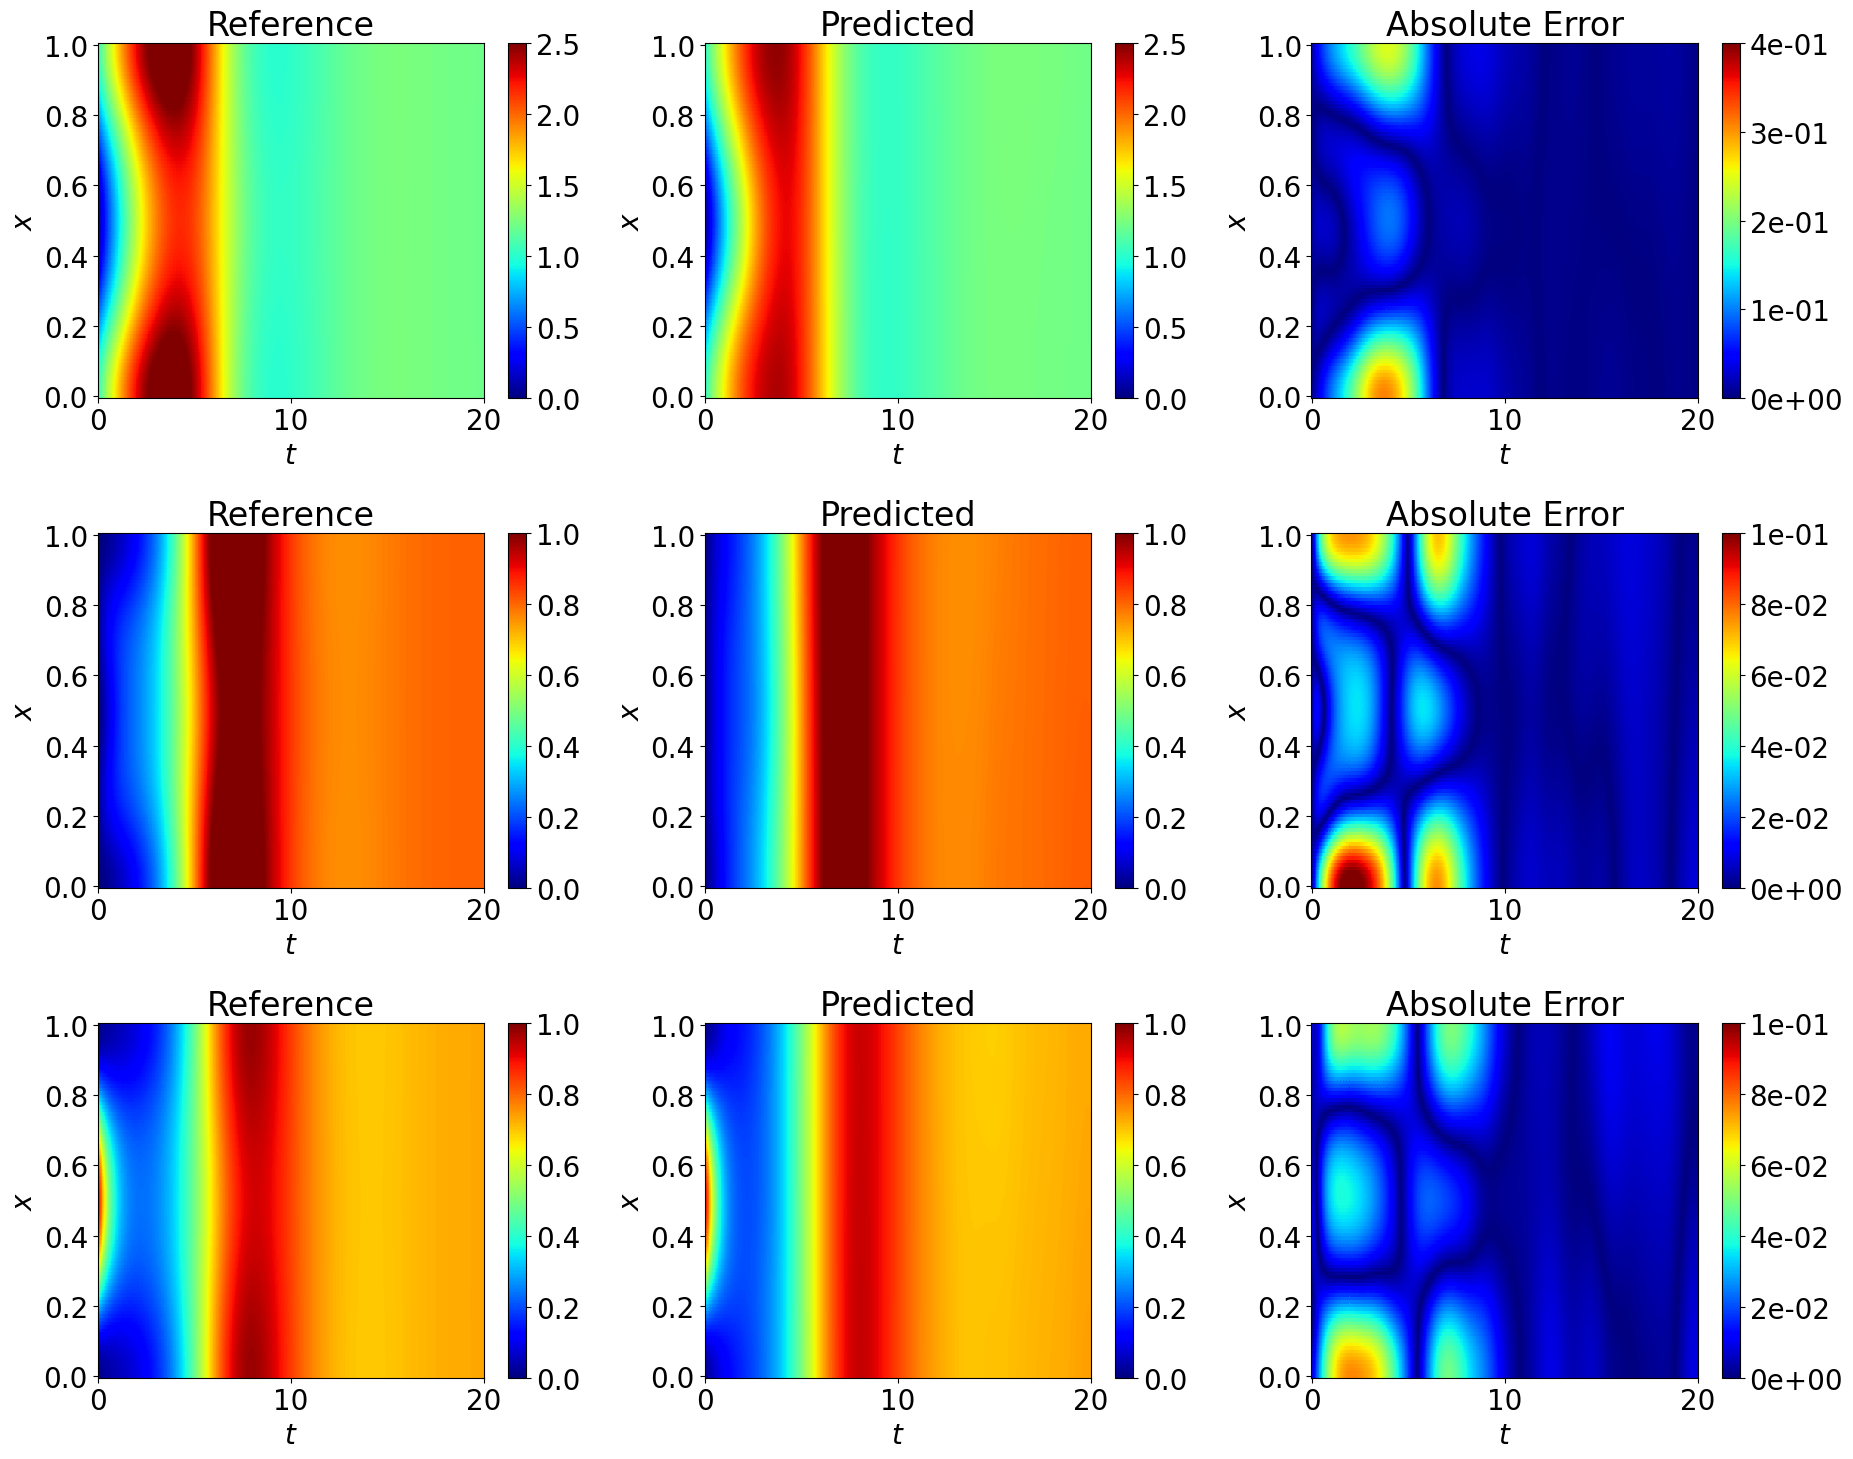

In [21]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig_1 = plt.figure(1, figsize=(19, 15))
plt.subplot(3, 3, 1)
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.5)
plt.pcolor(T, X, S, cmap='jet',norm=norm)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Reference')

plt.subplot(3, 3, 2)
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.5)
plt.pcolor(T, X, pred_s, cmap='jet',norm=norm)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Predicted')

plt.subplot(3, 3, 3)
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.4)
plt.pcolor(T, X, np.abs(S - pred_s), cmap='jet', norm=norm)
plt.colorbar(format='%.0e')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Absolute Error')

plt.subplot(3, 3, 4)
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
plt.pcolor(T, X, E, cmap='jet',norm=norm)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Reference')

plt.subplot(3, 3, 5)
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
plt.pcolor(T, X, pred_e, cmap='jet',norm=norm)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Predicted')

plt.subplot(3, 3, 6)
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.1)
plt.pcolor(T, X, np.abs(E - pred_e), cmap='jet', norm=norm)
plt.colorbar(format='%.0e')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Absolute Error')

plt.subplot(3, 3, 7)
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
plt.pcolor(T, X, I, cmap='jet',norm=norm)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Reference')

plt.subplot(3, 3, 8)
norm = matplotlib.colors.Normalize(vmin=0.0,vmax=1.0)
plt.pcolor(T, X, pred_i, cmap='jet',norm=norm)
plt.colorbar()
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Predicted')

plt.subplot(3, 3, 9)
norm = matplotlib.colors.Normalize(vmin=0,vmax=0.1)
plt.pcolor(T, X, np.abs(I - pred_i), cmap='jet',norm=norm)
plt.colorbar(format='%.0e')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Absolute Error')

plt.tight_layout()
plt.savefig('11.png')
plt.show()